<a href="https://colab.research.google.com/github/Alecia113/NLP-Emotional-analysis/blob/main/%E6%80%BB1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COMP5046 Assignment 1
*Make sure you change the file name with your unikey.*

In [ ]:
#改名

# Readme
*If there is something to be noted for the user, please mention here.* 

*If you are planning to implement a program with Object Oriented Programming style, please check the bottom of the this ipynb file*

In [2]:
#在这说明那个调用的获取两个文件的事情。

***Visualising the comparison of different results is a good way to justify your decision.***

[XXX] = 讲座/实验参考
说明你的决定）= 请在文件中说明你的决定/选择的理由。你必须在报告中用经验性的证据表明你的最终决定。
解释性能）= 请解释性能的趋势，以及为什么会出现这样的趋势的原因（或你的意见）。

# 1 - Data Preprocessing

## 1.1. Download Dataset

If you want to know how data has been saved in pickle file: see this [ipynb file](https://drive.google.com/file/d/1ZQUVBzgH7N2EbiyE3WTPx7JNe2eRTs36/view?usp=sharing)

In [4]:
# Code to download file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

id = '1lTD6bgRkmwguGAr30v-r0KBPdtnVneLb'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('testing_data.pkl')  

id = '1pCUdlZMoj99UZHtqFeza86fvVQfFmDFX'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('training_data.pkl')  

import pickle
training_data = pickle.load(open("training_data.pkl","rb"))
testing_data = pickle.load(open("testing_data.pkl","rb"))

print("------------------------------------")
print("Size of training dataset: {0}".format(len(training_data)))
print("Size of testing dataset: {0}".format(len(testing_data)))
print("------------------------------------")

print("------------------------------------")
print("Sample Data")
print("LABEL: {0} / SENTENCE: {1}".format(training_data[0][0], training_data[0][1]))
print("------------------------------------")


------------------------------------
Size of training dataset: 8000
Size of testing dataset: 2000
------------------------------------
------------------------------------
Sample Data
LABEL: neg / SENTENCE: hopeless for tmr :(
------------------------------------


## 1.2. Preprocess data



*You are required to describe which data preprocessing techniques were conducted with justification of your decision. *

**说明你的想法**

In [5]:
'''
# Please comment your code 评述你的代码 NLTK's Twitter_Sample dataset. 
# (Justify your decision) #[lab5]
'''
#[lab5]
import torch
#You can enable GPU here (cuda); or just CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#分集合;因为是给定的数据集都是数据+标签的形式，所以要把它分开

train_data = [training_data[i][1] for i in range(len(training_data))]
train_label = [training_data[i][0] for i in range(len(training_data))]

test_data = [testing_data[i][1] for i in range(len(testing_data))]  
test_label = [testing_data[i][0] for i in range(len(testing_data))] #neg pos

# 随机训练集 为了让模型训练的更好，因为给的训练集前面是前后分开的000111
#看起来不加也行，加了准确率就提升了。。；没加之前是得根据batch_size 来调整训练集，要不然会出现训练模型时候，准确度0.5/1恒定的情况。 虽然loss在变，但是分类的情况却没有变。
#[lab3]
zipped = zip(train_data,train_label)   #上图说明 b 调用一次之后，再调用的 c 则为空。如果想要复用这个结果，需要保存到 list 里，即：
Zipp = list(zipped) #如果直接 print(list(zipped))，则之后 zipped为空，因为已经用完一次迭代器了；如果想要复用这个结果，需要保存到 list 里
from random import shuffle

shuffle(Zipp)
train_data = [context[0] for context in Zipp]
train_label = [context[1] for context in Zipp]


#做预处理 变小写 [lab5] 因为小写的话更容易匹配字典中的元素。就不会出现有些小写有些大写的情况，让数据集更加工整，也为了后续处理删词什么的方便。
import pprint
text_train = [s.lower() for s in train_data]
text_test = [s.lower() for s in test_data]

# 分词[lab5] 因为就是需要一个个词的来处理。通过一个或者多个词来判断整个句子的关系，那么首先要判断每个词的关系。
import pprint
from nltk.tokenize import TweetTokenizer
tknzr = TweetTokenizer()


train_t=[]  #完全每句话的分词的集合。train_t[0][0]每个单词
for s in text_train:
  text_train = tknzr.tokenize(s)              #每句话分别作了分词 text_train[0]第一句话的分词
  train_t.append(text_train)  
        #:(    :-(


test_t=[]     #2000
for w in text_test:
  text_test = tknzr.tokenize(w)
  test_t.append(text_test)

# 删标点，这里是保留了一部分表情。但是后来发现，因为字典中没有表情，所以可以不保留表情[lab5]
#theprincesszooz but i see what youre going at   
#yes  subjective pain may not be real
#  but that does not make it less painful
'''
还得改
clean_doc2 = re.sub(r'[^\w\s]','',corpus[1])字符
clean_doc2 = re.sub(r'\d,'',corpus[1])数字
'''
import re
def remove(x):
  t = []
  for i in range(len(x)):
    t_sub = []        #是直接用空列表代替了
    for j in range(len(x[i])):
      if len(x[i][j])==0:
        continue
      if x[i][j] == " ":
        continue 
      else:
        x[i][j] = re.sub(r'\d','',x[i][j])                  #删除0-9
        if len(x[i][j]) == 1 or len(x[i][j]) > 3:           #and + or 问题。
          x[i][j] = re.sub(r'[^\w\s+]','', x[i][j])
        if len(x[i][j]) == 0:
          continue 
        else:
          t_sub.append(x[i][j]) 
    t.append(t_sub) 

  return t

text_train = remove(train_t)
text_test = remove(test_t)

##停用词  删除那些可有可无不影响句意比如a;an;the 但是又数目非常多的词。
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords as sw
stop_words = sw.words()
sww = sw.words()

text_train_le=[]    #8000
for tokens in text_train:
    filtered_sentence1 = [w for w in tokens if not w in stop_words]
    text_train_le.append(filtered_sentence1)


text_test_le=[]   #2000
for tokens in text_test:
  filtered_sentence2 = [w for w in tokens if not w in stop_words]
  text_test_le.append(filtered_sentence2)

#去掉复数 stemmer 词根不需要这部； 如果用就需要在neg和pos需要stemmer操作 保留是因为更加便捷。
#如果只保留原型lec…………那个，无法与现有给定字典一一匹配。

from nltk.stem.porter import *
stemmer = PorterStemmer()
#text_train_le = [text_train_le[i] for i in range(len(text_train_le))]
#singles = [stemmer.stem(plural) for plural in text_train_le[i] for i in range(len(text_train_le))]
train_stem = []
for i in range(len(text_train_le)):
  singles1 = []
  for plural in text_train_le[i]:
    singles1.append(stemmer.stem(plural))
  train_stem.append(singles1)

#print(train_stem[:5])

test_stem = []
for i in range(len(text_test_le)):
  singles2 = []
  for plural in text_test_le[i]:
    singles2.append(stemmer.stem(plural))
  test_stem.append(singles2)

#print(test_stem[:5])



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# 2 - Model Implementation

## 2.1. Word Embeddings

*You are required to describe which model was implemented (i.e. Word2Vec with CBOW, FastText with SkipGram, etc.) with justification of your decision *

我到底用了哪个

In [6]:
# Please comment your code
#是调用的gensim模型[lab2]
'''
还有好几个模型没做对比尝试呢
'''
#已经在上面预处理完了，然后就是建立模型。
from gensim.models import Word2Vec
wv_cbow_model = Word2Vec(sentences= train_stem + test_stem, size=100, window=5, min_count=2, workers=2, sg=0)
#训练模型
#看看单词
vocab = list(set(wv_cbow_model.wv.vocab.keys()))
print('vocabulary:', len(vocab), vocab[:5])

#找出某个词向量最相近的词集合。
req_count = 100
for key in wv_cbow_model.wv.similar_by_word('school', topn =100):   #'school'.decode("ISO-8859-1")
    if len(key[0])==5:  #最相近的五个字的词
        req_count -= 1
        print(key[0], key[1])
        if req_count == 0:
            break;

#查看相似度。看两个词的相似度
print(wv_cbow_model.wv.similarity('thing', 'hope'))
print(wv_cbow_model.wv.similarity('phone', 'sleep'))
#[lab4]
#训练
wv_cbow_model.save("cbow.model")
#训练 ； 存 取；训练。
cbow = Word2Vec.load("./cbow.model")  #只是训练的NLTK's Twitter_Sample dataset. cbow最原始的标记方法。
#再训练epochs训练多少epoch ##end_alpha ==learning rate final;   total_examples : count of sentences.10000
ep = 0
for i in range(10):
  cbow.train(sentences= train_stem + test_stem ,total_examples=wv_cbow_model.corpus_count, epochs=cbow.iter, compute_loss=True)
  #举个例子，已经训练好的word2vec词表有[“我”,“爱”,“你”]三个词，给定一个新语料[“我”,“喜”,“欢”,“你”]，新语料只会调整原有词中的“我”“你”的词向量表示，而不会将“喜”“欢”添加到词库中。
  ep += cbow.epochs
  print('Epoch: %d, train loss: %.5f'%(ep, cbow.get_latest_training_loss()))

vocabulary: 4327 ['mess', 'adult', 'emmalk', 'luciholland', 'theyll']
never 0.9998459815979004
today 0.9998406767845154
wanna 0.9998377561569214
peopl 0.9998365640640259
still 0.9998323917388916
thing 0.9998319745063782
would 0.9998302459716797
didnt 0.9998251795768738
watch 0.9998245239257812
alway 0.9998177886009216
think 0.9998166561126709
place 0.9998131990432739
right 0.9998109340667725
first 0.9998082518577576
sorri 0.9998074173927307
video 0.9998055696487427
start 0.9998016357421875
theyr 0.9998006820678711
could 0.9997966885566711
0.99989873
0.9997354


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


Epoch: 5, train loss: 343238.28125
Epoch: 10, train loss: 346970.87500
Epoch: 15, train loss: 331609.18750
Epoch: 20, train loss: 307619.15625
Epoch: 25, train loss: 294525.71875
Epoch: 30, train loss: 270511.87500
Epoch: 35, train loss: 275933.37500
Epoch: 40, train loss: 255952.92188
Epoch: 45, train loss: 229673.57812
Epoch: 50, train loss: 230397.76562


### 2.1.1. Data Preprocessing for Word Embeddings

*You are required to describe which preprocessing techniques were used with justification of your decision.*

In [7]:
# Please comment your code

### 2.1.2. Build Word Embeddings Model

*You are required to describe how hyperparameters were decided with justification of your decision.*

In [8]:
# Please comment your code

### 2.1.3. Train Word Embeddings Model

In [9]:
# Please comment your code

## 2.2. Lexicon Embeddings

### 2.2.1. Lexicon-based Embedding

*[Optional] You are required to describe why you would like to use more than one-dimensional embedding.*

我认为是为了包含更多的信息也就是特征，更加准确的去得到你输入的和你想要结果之间的某种关系。

In [10]:
# Please comment your code
#否定词"ISO-8859-1"==UTF-8
'''
这里需要具体说明把文件丢到哪里
'''
#核心想法，我去看了看这个文件，因为有一些文本介绍。我找到了每个文件的第一个词，然后把这些词重新取出来放到一个list中。
from google.colab import drive
drive.mount('/content/drive') #必须要挂载
not_words = [w.strip() for w in open('/content/drive/MyDrive/NLP/A1/E/opinion-lexicon-English/negative-words.txt', 'r', encoding="ISO-8859-1").readlines()]
#处理文件
j = -1
for i in not_words:
  j +=1
  if i == '2-faced':
    break
neg = not_words[j:]

#处理文件
sure_words = [w.strip() for w in open('/content/drive/MyDrive/NLP/A1/E/opinion-lexicon-English/positive-words.txt', 'r', encoding="ISO-8859-1").readlines()]

j = -1
for i in sure_words:
  j +=1
  if i == 'a+':
    break

pos = sure_words[j:]

#neg pos 词表
#要对他们做stem因为训练集做了stem

'''
前面要是后来测试发现不需要这里那就不用了。
或者存个模型。
'''
#[lab5]
#也要对他做stem #太久了。简直了 至少10-20分钟，太久了。 #该跑还是要跑。

neg_stem = []
for i in range(len(neg)):
  singles3 = []
  for plural in neg:
    singles3.append(stemmer.stem(plural))
  neg_stem.append(singles3)

print(neg_stem[:5])


pos_stem = []
for i in range(len(pos)):
  singles4 = []
  for plural in pos:
    singles4.append(stemmer.stem(plural))
  pos_stem.append(singles4)

print(pos_stem[:5])


Mounted at /content/drive
[['2-face', '2-face', 'abnorm', 'abolish', 'abomin', 'abomin', 'abomin', 'abomin', 'abort', 'abort', 'abort', 'abrad', 'abras', 'abrupt', 'abruptli', 'abscond', 'absenc', 'absent-mind', 'absente', 'absurd', 'absurd', 'absurdli', 'absurd', 'abus', 'abus', 'abus', 'abus', 'abysm', 'abysm', 'abyss', 'accident', 'accost', 'accurs', 'accus', 'accus', 'accus', 'accus', 'accus', 'accusingli', 'acerb', 'acerb', 'acerb', 'ach', 'ach', 'ach', 'achey', 'ach', 'acrid', 'acridli', 'acrid', 'acrimoni', 'acrimoni', 'acrimoni', 'adam', 'adamantli', 'addict', 'addict', 'addict', 'addict', 'admonish', 'admonish', 'admonishingli', 'admonish', 'admonit', 'adulter', 'adulter', 'adulter', 'adulteri', 'adversari', 'adversari', 'advers', 'advers', 'afflict', 'afflict', 'afflict', 'affront', 'afraid', 'aggrav', 'aggrav', 'aggrav', 'aggress', 'aggress', 'aggress', 'aggressor', 'aggriev', 'aggriev', 'aggriv', 'aghast', 'agoni', 'agon', 'agon', 'agonizingli', 'agoni', 'aground', 'ail', '

In [20]:
#字典的embedding ； 增加一个维度的 
#只需要先让他们对应起来。您要检查每个单词是在正还是负词典中not_exist（0），negative（1）和positive（2）
#一维句子，二维单词
#是要吧一句话变成【012组成的形式】
#现在就是一一对应的形式了。一句话;这个是train_stem【 as,ada,daff】 match_embedding【120】同一个索引在两个列表中 
# 就是用+-无来代替原本的一句话。为给他增加feature做准备
def match(text):
  sum_match= [] #train_match
  for i in range(len(text)):  #train_stem
    match = []
    for j in range(len(text[i])):
      if text[i][j] in neg_stem[0]:
        match.append(1)   #neg 1
      elif text[i][j] in pos_stem[0]:
        match.append(2) #pos 2
      else:
        match.append(0)
    sum_match.append(match)
  #print(sun_match[:5])
  #print(text[:5]) 
  return sum_match
train_match = match(train_stem)
test_match = match(test_stem)
#只有stem好用
print(train_match[:5])
print(test_match[:5])

[[0, 0, 2, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0], [0, 0, 0, 1, 2, 0, 0, 0, 0, 0], [0, 2, 2, 0], [0, 0, 1, 0]]
[[0, 2, 0, 0, 1, 0], [0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 2, 0, 0, 0], [0, 0, 0], [0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]


## 2.3. Bi-directional RNN Sequence model

### 2.3.1. Apply/Import Word Embedding and Lexicon Embedding

把词嵌入和字典嵌入连接起来。

In [21]:
# Please comment your code
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
import math
import numpy as np


#要的 防止OOV的问题 因为在做词向量的时候，出现的词数较小的忽略了词向量，所以我使用DF将所有词频低于 min_count 都不要。
#然后再将词向量和[lab1]
import pprint
def input(text):
  DF = {}

  for tokensized_doc in text: #text = train_stem  test_stem
      # get each unique word in the doc - and count the number of occurrences in the document
      for term in np.unique(tokensized_doc):
          try:
              DF[term] +=1
          except:
              DF[term] =1
  #DF 整个统计的词频。 保留DF大于2的词。 if DF[term]>=2 我就重新添加。
  input = []
  for w in range(len(text)):  #8000 0-7999
    num = 0
    new = []
    for t in text[w]: #一句话 #t就是这个单词  #13
      match = []  #目前这个就是第一句话的match
      if DF[t] >= 2:    #0-12     这个min_count
        word_vec = wv_cbow_model[t].tolist()
        match.append(train_match[w][num]) #w 012 []   #IndexError: list index out of range 后面的num问题
        new_embedding = word_vec + match   #sent_embedding
        new.append(new_embedding)
      num += 1
      if num >= len(train_match[w]):
        break
    input.append(new)  # input == train_embedding
  #print(input[0][0]) #input 8000一句话 3一个词 101 vec+0、1

  return input

input_train = input(train_stem) 
input_test = input(test_stem) 
#pprint.pprint(input_train[:1])
print('\n')
#pprint.pprint(input_test[:1])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


In [22]:
#主要是为了得到n_class
'''
已经串联完了，要给它扔进序列模型。
你要创建序列模型了。Build training sequence model
把你的输入扔到这里Bi-directional RNN-based (Bi-RNN or Bi-LSTM or Bi-GRU) 【N to1】(N: word, One: Sentiment - Positive or Negative)
自己决定超参
'''

#n你后面可是12
#[lab5]
import numpy as np

from sklearn.preprocessing import LabelEncoder

unique_labels = np.unique(train_label)

lEnc = LabelEncoder()
# Please encode the labels (Do NOT add new lines of code in this section)
# Hint: Try to understand the difference between fit_transform and transform
label_train_encoded = lEnc.fit_transform(train_label) #lEnc.transform(unique_labels)[0]+1
label_test_encoded = lEnc.fit_transform(test_label)

n_class = len(unique_labels)  #主要是为了得到n_class  #n_class = np.unique(unique_labels).shape[0] #2相当于
print(unique_labels)
print(lEnc.transform(unique_labels))
print(n_class)


##seq_length 参数怎么来的 --- 最大长度 因为丢入神经网络中的是要长度统一的句子。为了方便起见，我直接将句子都搞成最长的句子，
#这样只需要补0，不需要做删减。思路来源[lab5]

#要确定最大长度是多少 [lab4]
doc_length_list = []  #会得到8000句话
sum_text = train_stem + test_stem
maxlength = 0
for doc in sum_text:
    doc_length_list.append(len(doc))#每句话多少个分词

for index in range(len(doc_length_list)):
  if doc_length_list[index] > maxlength:
    maxlength = doc_length_list[index]
    max_index = index

#max = doc_length_list.index(max(doc_length_list))#python 寻找list中最大元素对应的索引方法
#doc_length_list[max] #maxlength
print(doc_length_list[max_index])


['neg' 'pos']
[0 1]
2
22


### 2.3.2. Build Sequence Model

*You are required to describe how hyperparameters were decided with justification of your decision.*

In [33]:
# Please comment your code
#超参的设置没什么大问题了 
# 调解超参主要是因为每次训练 训练集的准确度恒定在0.5 或者1 是因为样本的分布问题，0011的分布方式，所以当0.5的时候，通过调整
#如果被分成了正类，那么我就调大batch_size 调低学习率。
'''
如何确定超参数。
'''
#[lab4][lab5]
import numpy as np

seq_length = doc_length_list[max_index] #（22）应该是我规定的最大序列长度512那种  maxlength 增加减少那种 #一句话最长多少个词
n_input = len(input_train[0][0])  #101 无所谓的反正都是101维度
n_class = len(unique_labels) #2

n_hidden = 200  #128
batch_size = 800    #500 
total_epoch = 20  #10
learning_rate = 0.001 # 1e-4 == 0.001 le-3 == 0.01 #0.1  0.05


#把输入的规格都定成一样的， 变成句子长度是22，单词维度是101
#都变成一样长22 每个里面都是101   input_train   or  input_test
def sent_encoded(input_text):
  sent_encoded = []
  for m in range(len(input_text)): # m 1-8000 #训练集  input_train  input_test
    #n = 0
    encoded = [] 
  #for sen in input[m]: #把每个单词拿出来
    #n = 0            #取你合成的每个句子 第一个句子是3  i o y p o [0] [1]
    zero = []
    if len(input_text[m]) < seq_length:
      zero = [len(input_text[0][0])*[0]] * (seq_length - len(input_text[m]))#补充到22 最长 # 不单单加0； 还是需要变成101维度
      encoded = input_text[m] + zero
    else:
      encoded = input_text[m]
    sent_encoded.append(encoded) #要重新添加。 句子已经全变成22了 

  sent_encoded = np.array(sent_encoded)
  return sent_encoded

sent_encoded_train = sent_encoded(input_train)
sent_encoded_test = sent_encoded(input_test)
#print(sent_encoded_train[:1]) #(8000, 22, 101)
#print(sent_encoded_test[:1])#(2000, 22, 101)


#还是Bi-LSTM准确度更高，因为LSTM处理了记忆丢失的问题。
'''
要写个LSTM比RNN好在哪里。
'''
# 模型Bi-RNN

import torch.nn as nn
import torch.nn.functional as F
'''
class Bi_RNN_Model(nn.Module):
    def __init__(self):
        super(Bi_RNN_Model, self).__init__()
        # set the bidirectional to True
        self.rnn = nn.RNN(n_input, n_hidden, batch_first =True, bidirectional=True) #, dropout = 0.5
        self.linear = nn.Linear(2*n_hidden,n_class) #n_class = 3 
        #https://stackoverflow.com/questions/60259836/cnn-indexerror-target-2-is-out-of-bounds 虽然是01分类但是，pytorch 要进行012 
    def forward(self, x):        
        x, h_n = self.rnn(x)
        # concat the last hidden state from two direction
        hidden_out = torch.cat((h_n[0,:,:],h_n[1,:,:]),1)
        output = self.linear(hidden_out)
        return output


'''

#LSTM-BI
class Bi_LSTM_Model(nn.Module):
    def __init__(self):
        super(Bi_LSTM_Model, self).__init__()
        #self.emb = nn.Embedding(vocab_size, emb_dim)
        # Initialize the Embedding layer with the lookup table we created 
        #self.emb.weight.data.copy_(torch.from_numpy(emb_table))
        # Optional: set requires_grad = False to make this lookup table untrainable
        #self.emb.weight.requires_grad = False

        self.lstm = nn.LSTM(n_input, n_hidden, batch_first =True, bidirectional=True)
        self.linear = nn.Linear(n_hidden*2, n_class)

    def forward(self, x):
        # Get the embeded tensor
        #x = self.emb(x)        
        # we will use the returned h_n of shape (num_layers * num_directions, batch, hidden_size): tensor containing the hidden state for t = seq_len.
        # details of the outputs from nn.LSTM can be found from: https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html
        lstm_out, (h_n,c_n) = self.lstm(x)
        # concat the last hidden state from two direction
        hidden_out =torch.cat((h_n[0,:,:],h_n[1,:,:]),1)
        z = self.linear(hidden_out)
        return z

from sklearn.metrics import accuracy_score
import torch.optim as optim
'''
criterion = nn.CrossEntropyLoss()
model = Bi_RNN_Model().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
'''
#Bi-LSTM
# Move the model to GPU
criterion = nn.CrossEntropyLoss()
model = Bi_LSTM_Model().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)




### 2.3.3. Train Sequence Model

Note that it will not be marked if you do not display the Training Loss and the Number of Epochs in the Assignment 1 ipynb.


In [34]:
# Please comment your code
#[lab4][lab5]
#检查输出节点数与标签数是否一致。
#并且将输出节点数num_outputs更改为标签数。
# 因为我之前设置的class 类别是 0，1；所以这里也需要改成0，1 要不然后面会出现 target超出范围的错误。
def label(label):   
  label = np.array(label) #train_label
  #neg 1 pos2
  lab = []  #label_train
  for tag in label:
    if tag == 'neg':
      lab.append(0)
    else:
      lab.append(1)
  #print(label_train)
  #print(len(label_train))
  lab = np.array(lab)
  #test_label
  return lab

label_train = label(train_label)
label_test = label(test_label)

#要开始训练。 optimizer +loss+ backward

#处理
#sent_encoded_train = sent_encoded(input_train)
#sent_encoded_test = sent_encoded(input_test)

for epoch in range(total_epoch):
    train_loss = 0
    for ind in range(0,sent_encoded_train.shape[0],batch_size):
        input_batch = sent_encoded_train[ind:min(ind+batch_size, sent_encoded_train.shape[0])] #256,22,101
        target_batch = label_train[ind:min(ind+batch_size, sent_encoded_train.shape[0])]  #256
        input_batch_torch = torch.from_numpy(input_batch).float().to(device)  #256,22,101
        target_batch_torch = torch.from_numpy(target_batch).view(-1).to(device) #256

        model.train()
        optimizer.zero_grad()
        outputs = model(input_batch_torch)   #13,512,25 #256，22，101    #256 2 #500,22,101
        loss = criterion(outputs, target_batch_torch) #256 2    256 out,y
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    predicted = torch.argmax(outputs, 1)  # 输出值为元祖获取第二个tensor        
    acc = accuracy_score(predicted.cpu().numpy(),target_batch_torch.cpu().numpy())
    print('Epoch: %d, train loss: %.5f, train_acc:%.2f'%(epoch + 1, train_loss, acc))

print('Finished Training')
#这块是在后面评估，可删
## Prediction

model.eval()
outputs2 = model(torch.from_numpy(sent_encoded_test).float().to(device)) 
predicted2 = torch.argmax(outputs2, 1)

# classification_report builds a text report showing the main classification metrics
# The returned report includes the 'weighted avg f1' we want (refer to the sample output)
# More details can be found from: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html
from sklearn.metrics import classification_report


print(classification_report(label_test, predicted2.cpu().numpy(),digits=4))
#是改变了batch


Epoch: 1, train loss: 6.92268, train_acc:0.57
Epoch: 2, train loss: 6.85325, train_acc:0.59
Epoch: 3, train loss: 6.76679, train_acc:0.59
Epoch: 4, train loss: 6.66403, train_acc:0.60
Epoch: 5, train loss: 6.56795, train_acc:0.61
Epoch: 6, train loss: 6.53597, train_acc:0.60
Epoch: 7, train loss: 6.46048, train_acc:0.65
Epoch: 8, train loss: 6.19874, train_acc:0.68
Epoch: 9, train loss: 6.67182, train_acc:0.58
Epoch: 10, train loss: 6.48074, train_acc:0.65
Epoch: 11, train loss: 6.38228, train_acc:0.65
Epoch: 12, train loss: 6.10103, train_acc:0.72
Epoch: 13, train loss: 5.60110, train_acc:0.79
Epoch: 14, train loss: 6.14090, train_acc:0.68
Epoch: 15, train loss: 5.62167, train_acc:0.73
Epoch: 16, train loss: 4.85475, train_acc:0.81
Epoch: 17, train loss: 4.52319, train_acc:0.85
Epoch: 18, train loss: 4.75780, train_acc:0.80
Epoch: 19, train loss: 3.65894, train_acc:0.85
Epoch: 20, train loss: 3.17596, train_acc:0.88
Finished Training
              precision    recall  f1-score   suppo

# 3 - Evaluation


## 3.1. Word Embedding Evaluation
You are to apply Semantic-Syntactic word relationship tests for the trained word embeddings and visualise the result of Semantic-Syntactic word relationship tests.
Note that it will not be marked if you do not display it in the ipynb file.


(*Please show your empirical evidence*)

In [25]:
# Please comment your code
#要用语义，句法词关系来测试。[lab5-word_analogy_evaluation]
#https://colab.research.google.com/drive/1VdNkQpeI6iLPHeTsGe6sdHQFcGyV1Kmi?usp=sharing#scrollTo=EVk7tjwvhl-6

'''
需要来个w2v大合集
'''
#评估类比测试集。 analogy 类比
!git clone https://github.com/stanfordnlp/GloVe.git

'''
这个地方要多训练+要搞个别的名字，不能再是cbow了，那之前的就用原始能力名字，这里就用其他的长名字
'''
wv_cbow_model.save("cbow.model")
#训练 ； 存 取；训练。
cbow = Word2Vec.load("./cbow.model")
cbow.train(sentences= train_stem + test_stem ,total_examples=wv_cbow_model.corpus_count, epochs=cbow.iter)
#可以把训练完的存成文本。
wv_cbow_model.wv.save_word2vec_format('cbow.txt',binary=False)
#打卡训练好的文件
vectors_file="/content/cbow.txt"
#匹配
with open(vectors_file, 'r') as f:
  vectors = {}
  for line in f.readlines()[1:]: # we only need the embedding vectors starting from the second line 
    vals = line.rstrip().split(' ')
    vectors[vals[0]] = [x for x in vals[1:]]

#处理
vocab_words=list(vectors.keys())
vocab_size = len(vocab_words)
print("Vocab size: ",str(vocab_size))

# create word->index and index->word converter  
vocab = {w: idx for idx, w in enumerate(vocab_words)} #每个单词对应个index
ivocab = {idx: w for idx, w in enumerate(vocab_words)}  #每个index对应一个单词


# create the embedding matrix of shape (vocab_size, dim)
vector_dim = len(vectors[ivocab[0]])  #100
W = np.zeros((vocab_size, vector_dim))    #4325.100
for word, v in vectors.items():
    if word == '<unk>' or word == '':
        continue
    
    W[vocab[word], :] = v   #100 102

# normalize each word vector to unit length
# Vectors are usually normalized to unit length before they are used for similarity calculation, making cosine similarity and dot-product equivalent.
W_norm = np.zeros(W.shape)
d = (np.sum(W ** 2, 1) ** (0.5))
W_norm = (W.T / d).T

#开始句法文本分析各种的功能语句。

def evaluate_vectors(W, vocab, prefix='./content/GloVe/eval/question-data/'):#/content/GloVe/eval/question-data
    """Evaluate the trained word vectors on a variety of tasks"""

    filenames = [
        'capital-common-countries.txt', 'capital-world.txt', 'currency.txt',
        'city-in-state.txt', 'family.txt', 'gram1-adjective-to-adverb.txt',
        'gram2-opposite.txt', 'gram3-comparative.txt', 'gram4-superlative.txt',
        'gram5-present-participle.txt', 'gram6-nationality-adjective.txt',
        'gram7-past-tense.txt', 'gram8-plural.txt', 'gram9-plural-verbs.txt',
        ]

    # to avoid memory overflow, could be increased/decreased
    # depending on system and vocab size
    split_size = 100

    correct_sem = 0; # count correct semantic questions  计算正确的语义问题
    correct_syn = 0; # count correct syntactic questions 计算正确的句法问题
    correct_tot = 0 # count correct questions   计算正确的问题
    count_sem = 0; # count all semantic questions 计算所有语义问题
    count_syn = 0; # count all syntactic questions  计算所有语法问题
    count_tot = 0 # count all questions   计算所有问题  
    full_count = 0 # count all questions, including those with unknown words    计算所有问题包括不知道n个单词的问题

    for i in range(len(filenames)):
        with open('%s/%s' % (prefix, filenames[i]), 'r') as f:
            full_data = [line.rstrip().split(' ') for line in f]
            full_count += len(full_data)
            data = [x for x in full_data if all(word in vocab for word in x)]

        if len(data) == 0:
            print("ERROR: no lines of vocab kept for %s !" % filenames[i])
            print("Example missing line:", full_data[0])
            continue

        indices = np.array([[vocab[word] for word in row] for row in data])
        ind1, ind2, ind3, ind4 = indices.T

        predictions = np.zeros((len(indices),))
        num_iter = int(np.ceil(len(indices) / float(split_size)))
        for j in range(num_iter):
            subset = np.arange(j*split_size, min((j + 1)*split_size, len(ind1)))

            pred_vec = (W[ind2[subset], :] - W[ind1[subset], :]
                +  W[ind3[subset], :])

            #cosine similarity if input W has been normalized
            dist = np.dot(W, pred_vec.T)


            for k in range(len(subset)):
                dist[ind1[subset[k]], k] = -np.Inf
                dist[ind2[subset[k]], k] = -np.Inf
                dist[ind3[subset[k]], k] = -np.Inf

            # predicted word index
            predictions[subset] = np.argmax(dist, 0).flatten()

        
        val = (ind4 == predictions) # correct predictions
        count_tot = count_tot + len(ind1) #216
        correct_tot = correct_tot + sum(val)
        if i < 5:
            count_sem = count_sem + len(ind1)
            correct_sem = correct_sem + sum(val)
        else:
            count_syn = count_syn + len(ind1)
            correct_syn = correct_syn + sum(val)

        print("%s:" % filenames[i])
        print('ACCURACY TOP1: %.2f%% (%d/%d)' %
            (np.mean(val) * 100, np.sum(val), len(val)))
        
    return correct_sem, correct_syn, correct_tot, count_sem, count_syn, count_tot, full_count

#可视化展示
correct_sem, correct_syn, correct_tot, count_sem, count_syn, count_tot, full_count = evaluate_vectors(W_norm, vocab, prefix='/content/GloVe/eval/question-data')#/content/GloVe/eval/question-data
print('Questions seen/total: %.2f%% (%d/%d)' %    #看到的问题
    (100 * count_tot / float(full_count), count_tot, full_count))
print('Semantic accuracy: %.2f%%  (%i/%i)' %  #语义准确度
    (100 * correct_sem / float(count_sem), correct_sem, count_sem))
print('Syntactic accuracy: %.2f%%  (%i/%i)' % #语法准确度
    (100 * correct_syn / float(count_syn), correct_syn, count_syn))
print('Total accuracy: %.2f%%  (%i/%i)' % (100 * correct_tot / float(count_tot), correct_tot, count_tot))
  #总准确度

## 3.2. Performance Evaluation


You are required to provide the table with precision, recall, f1 of test set.
Note that it will not be marked if you do not display it in the ipynb file.


(*Please show your empirical evidence*)

In [26]:
# Please comment your code
#[lab4]在展示report说明性能。

## Prediction

model.eval()
outputs2 = model(torch.from_numpy(sent_encoded_test).float().to(device)) 
predicted2 = torch.argmax(outputs2, 1)

# classification_report builds a text report showing the main classification metrics
# The returned report includes the 'weighted avg f1' we want (refer to the sample output)
# More details can be found from: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html
from sklearn.metrics import classification_report


print(classification_report(label_test, predicted2.cpu().numpy(),digits=4))
#是改变了batch



              precision    recall  f1-score   support

           0     0.5584    0.6120    0.5840      1000
           1     0.5708    0.5160    0.5420      1000

    accuracy                         0.5640      2000
   macro avg     0.5646    0.5640    0.5630      2000
weighted avg     0.5646    0.5640    0.5630      2000



## 3.3. Hyperparameter Testing
*You are required to draw a graph(y-axis: f1, x-axis: epoch) for test set and explain the optimal number of epochs based on the learning rate you have already chosen.* Note that it will not be marked if you do not display it in the ipynb file.


(*Please show your empirical evidence*)

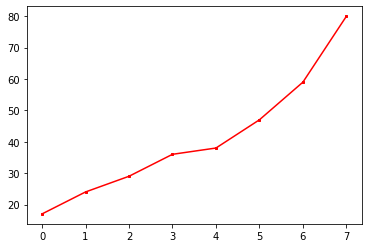

In [27]:
# Please comment your code
#先把f1取出来，然后每训练一次存一次。
from sklearn.metrics import f1_score
f1 = f1_score(label_test, predicted2.cpu().numpy(),average='macro') #f1出来了。 真实，预测，没跑一次就一个结果。
'''
torch.save(model,'save.pt')
model.load_state_dict(torch.load("save.pt"))  #model.load_state_dict()函数把加载的权重复制到模型的权重中去
'''

#能一次存很多的东西。
torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, 'save.PATH')

II = torch.load('save.PATH')
O=model.load_state_dict(II['model_state_dict']) #成功
optimizer.load_state_dict(II['optimizer_state_dict'])
PP = II['epoch'] #19
LL = II['loss'] #0.6927

model.eval()
model.train()

'''
在保存用于推理或者继续训练的常规检查点的时候，除了模型的state_dict之外，还必须保存其他参数。保存优化器的state_dict也非常重要，因为它包含了模型在训练时候优化器的缓存和参数。除此之外，还可以保存停止训练时epoch数，最新的模型损失，额外的torch.nn.Embedding层等。

要保存多个组件，则将它们放到一个字典中，然后使用torch.save()序列化这个字典。一般来说，使用.tar文件格式来保存这些检查点。

加载各个组件，首先初始化模型和优化器，然后使用torch.load()加载保存的字典，然后可以直接查询字典中的值来获取保存的组件。

同样，评估模型的时候一定不要忘了调用model.eval()。
'''


#  x是epoch y是f1 测试集
import matplotlib.pyplot as plt
#for epoch in range(total_epoch):  
#x = [5, 10, 15, 20, 25, 30, 35, 40]
x = [epoch for epoch in range(8)]
y = [17, 24, 29, 36, 38, 47, 59, 80]
plt.plot(x,y,'rs-',markersize =2) # 那个点
plt.show()
# precision: TP/(TP+FP)
#recall


## Object Oriented Programming codes here

*You can use multiple code snippets. Just add more if needed* 

In [28]:
# If you used OOP style, use this section